Hierarchical CNN (HCNN) for Text Classification

 Install Required Libraries

In [1]:
!pip install tensorflow keras pandas scikit-learn -q

import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Load and Explore Data

Dataset shape: (30000, 3)

Columns: ['text', 'category', 'label']

First few rows:
                                                text       category  label
0  ethan hawke julie delpy pick left midnight eth...  ENTERTAINMENT      3
1  tom cruise forced choose scientology suri tom ...  ENTERTAINMENT      3
2  would pay wine beer glass made cheese heart me...  ENTERTAINMENT      3
3                    tyga denies dating kylie jenner  ENTERTAINMENT      3
4  review laughfest subversively family friendly ...  ENTERTAINMENT      3

Unique categories: 15

Label distribution:
label
0     2000
1     2000
2     2000
3     2000
4     2000
5     2000
6     2000
7     2000
8     2000
9     2000
10    2000
11    2000
12    2000
13    2000
14    2000
Name: count, dtype: int64

Text length statistics:
count    30000.000000
mean        17.633600
std          7.196968
min          5.000000
25%         13.000000
50%         17.000000
75%         22.000000
max        108.000000
Name: text_length, dtype:

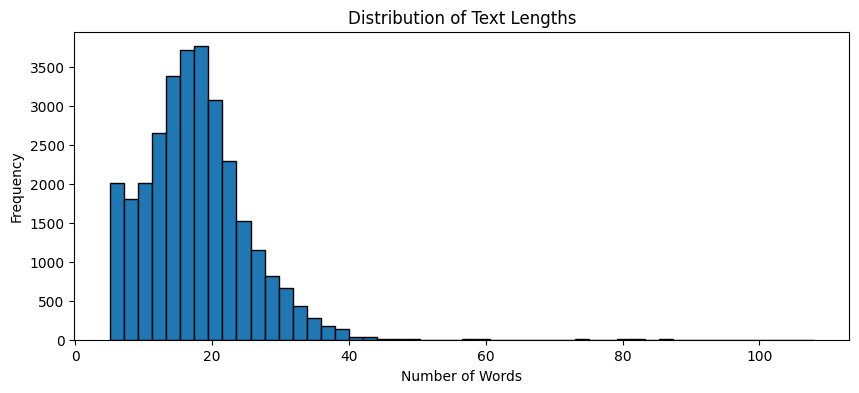

In [2]:
# Load data
df = pd.read_csv('news_preprocessed.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nUnique categories: {df['category'].nunique()}")
print(f"\nLabel distribution:")
print(df['label'].value_counts().sort_index())

# Check text lengths
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
print(f"\nText length statistics:")
print(df['text_length'].describe())

plt.figure(figsize=(10, 4))
plt.hist(df['text_length'], bins=50, edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

Prepare Data for HCNN

In [4]:
# Parameters
MAX_WORDS = 10000        # Vocabulary size
MAX_SEQUENCE_LENGTH = 200  # Max number of words per text
EMBEDDING_DIM = 100      # Word embedding dimension

# Prepare texts and labels
texts = df['text'].astype(str).tolist()
labels = df['label'].values

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 24000
Validation samples: 3000
Test samples: 3000


Save Data Splits

In [5]:
# Save data splits
data_splits = {
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test
}

with open('data_splits.pkl', 'wb') as f:
    pickle.dump(data_splits, f)

print("✅ Data splits saved as 'data_splits.pkl'")

✅ Data splits saved as 'data_splits.pkl'


Tokenization and Padding

In [6]:
# Create tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Training data shape: {X_train_pad.shape}")

# Get number of classes
num_classes = len(np.unique(labels))
print(f"Number of classes: {num_classes}")

Vocabulary size: 30903
Training data shape: (24000, 200)
Number of classes: 15


 Build Hierarchical CNN Architecture

In [7]:
def build_hcnn(vocab_size, embedding_dim, max_length, num_classes):
    """
    Hierarchical CNN Architecture:
    - Embedding layer
    - Multiple parallel CNN layers with different filter sizes (capturing different n-grams)
    - Max pooling
    - Dense layers for classification
    """

    # Input
    input_layer = layers.Input(shape=(max_length,))

    # Embedding layer
    embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length
    )(input_layer)

    # Dropout after embedding
    embedding = layers.Dropout(0.2)(embedding)

    # Multiple CNN branches with different kernel sizes
    # This captures different n-gram patterns (unigrams, bigrams, trigrams, etc.)

    # Branch 1: Kernel size 2 (bigrams)
    conv1 = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(embedding)
    conv1 = layers.GlobalMaxPooling1D()(conv1)

    # Branch 2: Kernel size 3 (trigrams)
    conv2 = layers.Conv1D(filters=128, kernel_size=3, activation='relu')(embedding)
    conv2 = layers.GlobalMaxPooling1D()(conv2)

    # Branch 3: Kernel size 4 (4-grams)
    conv3 = layers.Conv1D(filters=128, kernel_size=4, activation='relu')(embedding)
    conv3 = layers.GlobalMaxPooling1D()(conv3)

    # Branch 4: Kernel size 5 (5-grams)
    conv4 = layers.Conv1D(filters=128, kernel_size=5, activation='relu')(embedding)
    conv4 = layers.GlobalMaxPooling1D()(conv4)

    # Concatenate all branches
    merged = layers.Concatenate()([conv1, conv2, conv3, conv4])

    # Dense layers
    dense1 = layers.Dense(256, activation='relu')(merged)
    dense1 = layers.Dropout(0.5)(dense1)

    dense2 = layers.Dense(128, activation='relu')(dense1)
    dense2 = layers.Dropout(0.3)(dense2)

    # Output layer
    output = layers.Dense(num_classes, activation='softmax')(dense2)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output)

    return model

# Build the model
model = build_hcnn(
    vocab_size=MAX_WORDS,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    num_classes=num_classes
)

# Display model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 100)  │  1,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200, 100)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 199, 128)  │     25,728 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 198, 128)  │     38,528 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 197, 128)  │     51,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 196, 128)  │     64,128 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 15)        │      1,935 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,345,871 (5.13 MB)

 Trainable params: 1,345,871 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

Compile the Model

In [8]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully!")

✅ Model compiled successfully!


Setup Callbacks

In [9]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_hcnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

Train the Model

In [10]:
# Train
print("🚀 Starting training...\n")

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")

🚀 Starting training...

Epoch 1/20
371/375 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1001 - loss: 2.6438
Epoch 1: val_accuracy improved from -inf to 0.40933, saving model to best_hcnn_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.1012 - loss: 2.6412 - val_accuracy: 0.4093 - val_loss: 1.8610 - learning_rate: 0.0010
Epoch 2/20
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4553 - loss: 1.7086
Epoch 2: val_accuracy improved from 0.40933 to 0.58167, saving model to best_hcnn_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4556 - loss: 1.7080 - val_accuracy: 0.5817 - val_loss: 1.4351 - learning_rate: 0.0010
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6553 - loss: 1.1676
Epoch 3: val_accuracy improved from 0.58167 to 0.59733, saving model to best_hcnn_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6553 - loss: 1.1676 - val_accuracy: 0.5973 - val_loss: 1.3957 - learning_rate: 0.0010
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7563 - loss: 0.8266
Epoch 4: val_accuracy improved from 0.59733 to 0.59967, saving model to best_hcnn_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7563 - loss: 0.8266 - val_accuracy: 0.5997 - val_loss: 1.5042 - learning_rate: 0.0010
Epoch 5/20
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8263 - loss: 0.5950
Epoch 5: val_accuracy improved from 0.59967 to 0.60067, saving model to best_hcnn_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8262 - loss: 0.5953 - val_accuracy: 0.6007 - val_loss: 1.6294 - learning_rate: 0.0010
Epoch 6/20
370/375 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8668 - loss: 0.4534
Epoch 6: val_accuracy did not improve from 0.60067

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8667 - loss: 0.4538 - val_accuracy: 0.5947 - val_loss: 1.7988 - learning_rate: 0.0010
Epoch 7/20
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9110 - loss: 0.2938
Epoch 7: val_accuracy did not improve from 0.60067
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9109 - loss: 0.2938 - val_accuracy: 0.5973 - val_loss: 2.0405 - learning_rate: 5.0000e-04
Epoch 8/20
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9398 - loss: 0.2044
Epoch 8: val_accuracy did not improve from 0.60067
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9398 - loss: 0.2044 - val_acc

Plot Training History

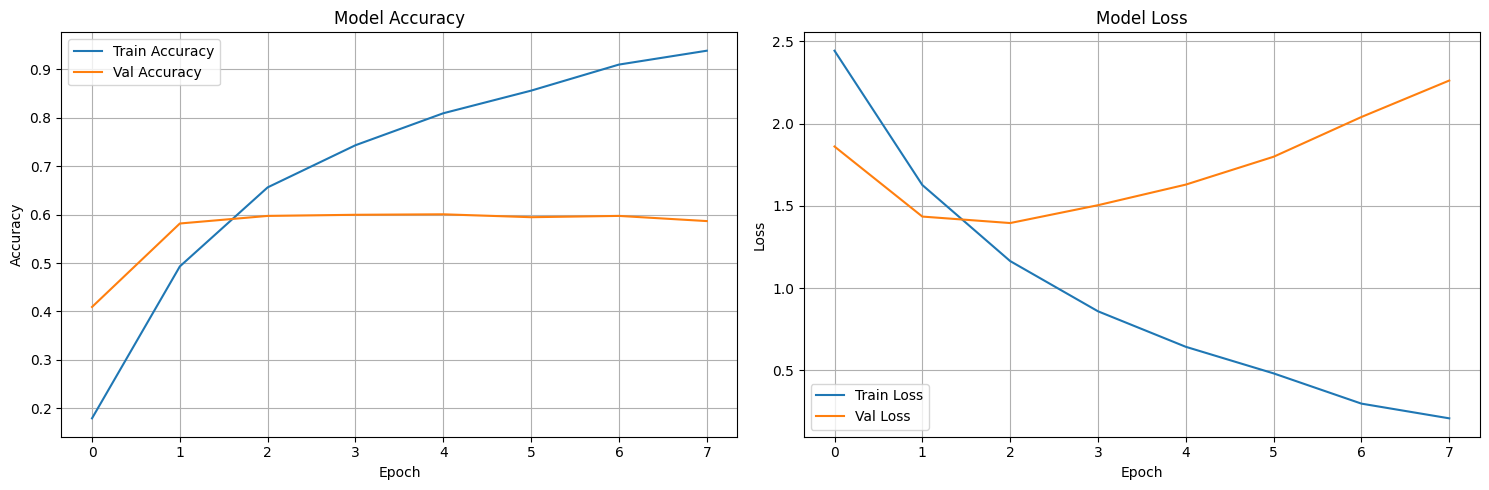

In [11]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Evaluate on Test Set

In [12]:
# Load best model
model.load_weights('best_hcnn_model.h5')

# Predict on test set
print("📊 Evaluating on test set...\n")
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get predictions
y_pred_probs = model.predict(X_test_pad, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_pred))

📊 Evaluating on test set...

Test Loss: 1.6028
Test Accuracy: 0.5970 (59.70%)

📋 Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.46      0.53       200
           1       0.54      0.46      0.50       200
           2       0.71      0.64      0.67       200
           3       0.42      0.46      0.44       200
           4       0.55      0.61      0.58       200
           5       0.63      0.84      0.72       200
           6       0.51      0.43      0.46       200
           7       0.60      0.55      0.57       200
           8       0.62      0.55      0.58       200
           9       0.75      0.83      0.79       200
          10       0.73      0.70      0.71       200
          11       0.57      0.72      0.64       200
          12       0.53      0.50      0.52       200
          13       0.51      0.55      0.53       200
          14       0.64      0.67      0.65       200

    accuracy         

Confusion Matrix

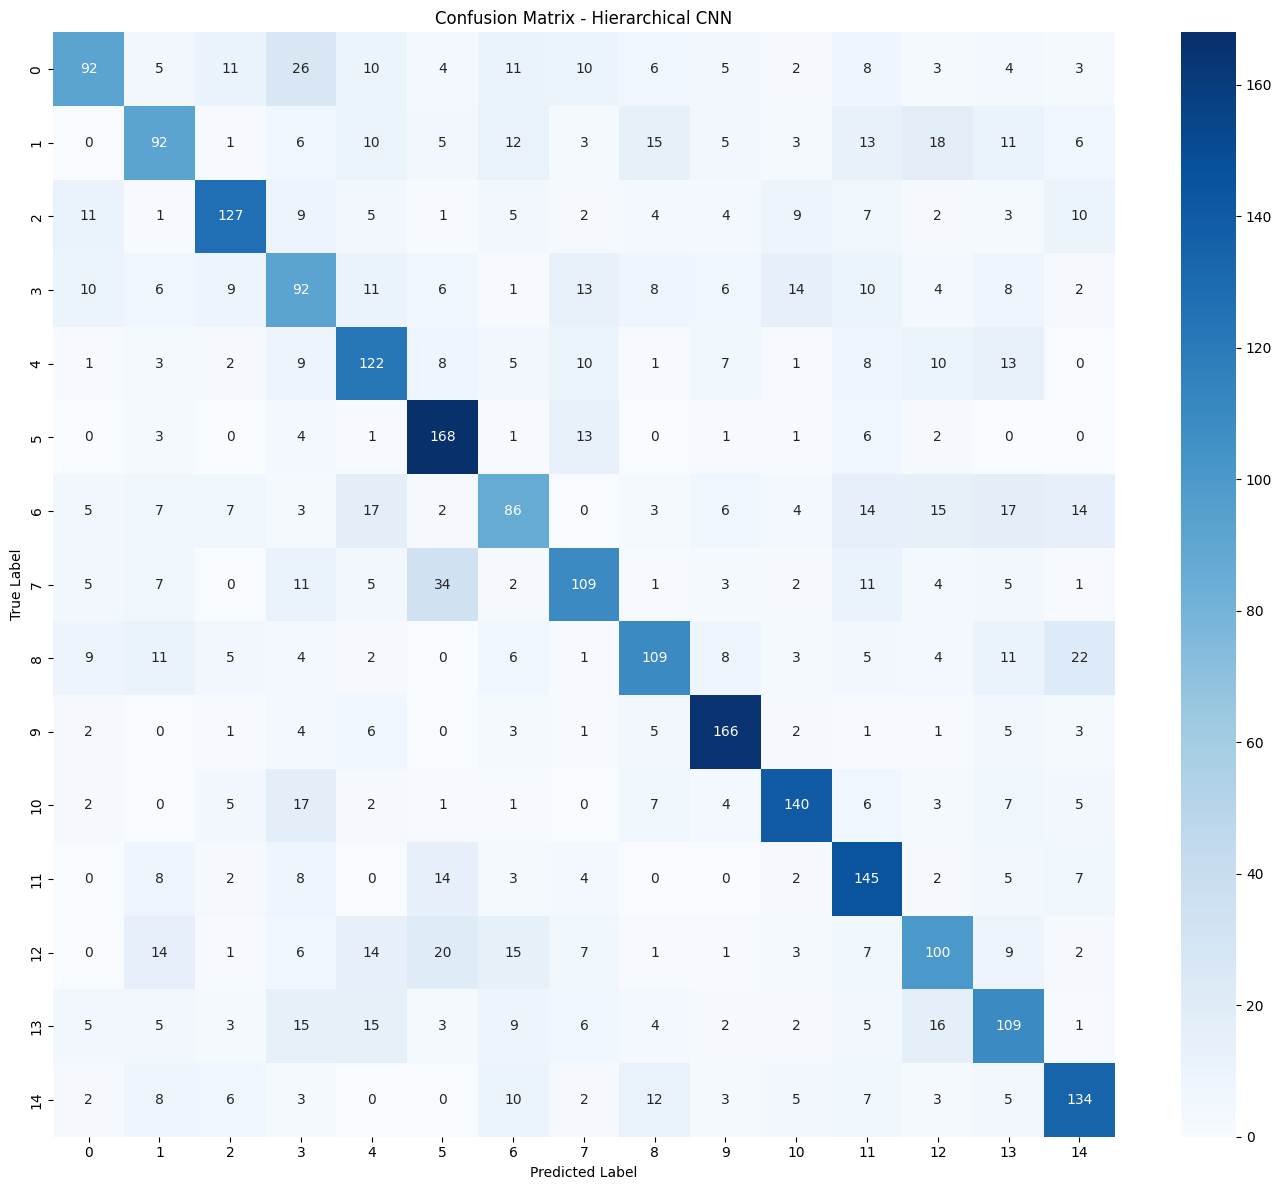


Per-class Accuracy:
Class 0: 0.4600 (46.00%)
Class 1: 0.4600 (46.00%)
Class 2: 0.6350 (63.50%)
Class 3: 0.4600 (46.00%)
Class 4: 0.6100 (61.00%)
Class 5: 0.8400 (84.00%)
Class 6: 0.4300 (43.00%)
Class 7: 0.5450 (54.50%)
Class 8: 0.5450 (54.50%)
Class 9: 0.8300 (83.00%)
Class 10: 0.7000 (70.00%)
Class 11: 0.7250 (72.50%)
Class 12: 0.5000 (50.00%)
Class 13: 0.5450 (54.50%)
Class 14: 0.6700 (67.00%)


In [13]:
# Confusion matrix
plt.figure(figsize=(14, 12))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix - Hierarchical CNN')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, acc in enumerate(class_accuracy):
    print(f"Class {i}: {acc:.4f} ({acc*100:.2f}%)")

Save Model and Preprocessing Objects

In [14]:
# Save the model
model.save('hcnn_news_classifier.h5')
print("✅ Model saved as 'hcnn_news_classifier.h5'")

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved as 'tokenizer.pkl'")

# Save label mapping
label_mapping = df[['category', 'label']].drop_duplicates().sort_values('label')
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_mapping, f)
print("✅ Label encoder saved as 'label_encoder.pkl'")

# Save config
config = {
    'MAX_WORDS': MAX_WORDS,
    'MAX_SEQUENCE_LENGTH': MAX_SEQUENCE_LENGTH,
    'EMBEDDING_DIM': EMBEDDING_DIM,
    'num_classes': num_classes
}
with open('hcnn_config.pkl', 'wb') as f:
    pickle.dump(config, f)
print("✅ Config saved as 'hcnn_config.pkl'")

✅ Model saved as 'hcnn_news_classifier.h5'
✅ Tokenizer saved as 'tokenizer.pkl'
✅ Label encoder saved as 'label_encoder.pkl'
✅ Config saved as 'hcnn_config.pkl'


Test Predictions

In [15]:
def predict_text(text, model, tokenizer, label_mapping, max_length):
    """Predict category for a given text"""

    # Preprocess
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Predict
    prediction = model.predict(padded, verbose=0)
    pred_label = np.argmax(prediction[0])
    confidence = prediction[0][pred_label]

    # Get category name
    category = label_mapping[label_mapping['label'] == pred_label]['category'].values[0]

    print(f"Text: {text[:100]}...")
    print(f"Predicted Category: {category}")
    print(f"Confidence: {confidence*100:.2f}%")
    print(f"Top 3 predictions:")
    top_3_idx = np.argsort(prediction[0])[-3:][::-1]
    for idx in top_3_idx:
        cat = label_mapping[label_mapping['label'] == idx]['category'].values[0]
        print(f"  - {cat}: {prediction[0][idx]*100:.2f}%")
    print()

# Test with examples
predict_text("The Lakers won the championship game last night", model, tokenizer, label_mapping, MAX_SEQUENCE_LENGTH)
predict_text("New study shows benefits of meditation for mental health", model, tokenizer, label_mapping, MAX_SEQUENCE_LENGTH)
predict_text("Stock market reaches all-time high today", model, tokenizer, label_mapping, MAX_SEQUENCE_LENGTH)
predict_text("Tips for healthy eating and meal preparation", model, tokenizer, label_mapping, MAX_SEQUENCE_LENGTH)

Text: The Lakers won the championship game last night...
Predicted Category: SPORTS
Confidence: 99.24%
Top 3 predictions:
  - SPORTS: 99.24%
  - ENTERTAINMENT: 0.52%
  - WORLDPOST: 0.07%

Text: New study shows benefits of meditation for mental health...
Predicted Category: WELLNESS
Confidence: 98.75%
Top 3 predictions:
  - WELLNESS: 98.75%
  - FOOD: 0.54%
  - BUSINESS: 0.23%

Text: Stock market reaches all-time high today...
Predicted Category: BUSINESS
Confidence: 53.65%
Top 3 predictions:
  - BUSINESS: 53.65%
  - TRAVEL: 23.07%
  - WELLNESS: 9.63%

Text: Tips for healthy eating and meal preparation...
Predicted Category: FOOD
Confidence: 95.48%
Top 3 predictions:
  - FOOD: 95.48%
  - LIFESTYLE: 4.13%
  - TRAVEL: 0.18%



Load Model Later (For Future Use)

In [16]:
# Load everything back
from tensorflow import keras
import pickle

# Load model
loaded_model = keras.models.load_model('hcnn_news_classifier.h5')

# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    loaded_tokenizer = pickle.load(f)

# Load label mapping
with open('label_encoder.pkl', 'rb') as f:
    loaded_label_mapping = pickle.load(f)

# Load config
with open('hcnn_config.pkl', 'rb') as f:
    loaded_config = pickle.load(f)

print("✅ All components loaded successfully!")

# Now you can use predict_text with loaded objects
predict_text(
    "Breaking news about political developments",
    loaded_model,
    loaded_tokenizer,
    loaded_label_mapping,
    loaded_config['MAX_SEQUENCE_LENGTH']
)

✅ All components loaded successfully!
Text: Breaking news about political developments...
Predicted Category: ENTERTAINMENT
Confidence: 53.06%
Top 3 predictions:
  - ENTERTAINMENT: 53.06%
  - POLITICS: 13.42%
  - SPORTS: 10.38%

